Test compositional lotka volterra algorithm on human gut time series (female test person).

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

from compositional_lotka_volterra_alr import *

# Import dataset

### Read data

In [16]:
# path of data file
subject = "donorB"
tax_level = "Genus"
# filename = f"ts_{subject}_rel_counts_{tax_level}Level_most_abundant.csv"
filename = f"ts_{subject}_{tax_level}_10_most_abundant_rel_counts.csv"
# filename = f"ts_{subject}_{tax_level}_10_most_abundant_mean_rel_counts.csv"
filepath = "C:/Users/Maria/Documents/Masterstudium/Masterarbeit/MScThesis/explore/data/final_datasets/"
# filepath = "C:/Users/Maria/Documents/Masterstudium/Masterarbeit/MScThesis/data/"

In [17]:
# function to import the datafile and put it into the right format
def create_data():
    data = pd.read_csv(f'{filepath}{filename}', sep=",", header=0)
    names = list(data.columns)[1:]
    usol = data.to_numpy()
    ts = usol[:, 0]
    data_y = usol[:, 1:]
    # set dimensions of the dataset
    global n_samples, n_taxa
    n_samples, n_taxa = data_y.shape
    print("The coodinates have shape {}".format(ts.shape))
    print("The data has shape {}".format(data_y.shape)) 
    return [ts], [data_y], names

In [18]:
T, Y, Names = create_data()

The coodinates have shape (253,)
The data has shape (253, 11)


In [19]:
U = [ np.zeros((x.shape[0], 1)) for x in Y ]

### Prepare data

In [20]:
# P then does not contain zero values
P = []
Y_pc = []
log_Y = []
for y in Y:
    mass = y.sum(axis=1)
    p = y / y.sum(axis=1,keepdims=True)
    p = (p + 1e-5) / (p + 1e-5).sum(axis=1,keepdims=True)
    P.append(p)
    Y_pc.append((mass.T*p.T).T)
    log_Y.append(np.log(mass.T*p.T).T)

In [21]:
np.seterr(divide="ignore", invalid="ignore")
vars = []
log_change = None
for p in P:
    s = p.sum(axis=1,keepdims=True)
    s[s==0] = 1
    deltas = np.log( (p/s)[1:] ) - np.log( (p/s)[:-1] )
    if log_change is None:
        log_change = deltas
    else:
        log_change = np.vstack((log_change, deltas))
np.seterr(divide="warn", invalid="warn")
# pick taxon with smallest change in log proportion
min_idx = -1
min_var = np.inf
ntaxa = log_change.shape[1]
for i in range(ntaxa):
    if not np.all(np.isfinite(log_change[:,i])):
        continue
    var = np.var(log_change[:,i])
    vars.append(var)


In [22]:
# get list of taxa (indices) that are not zero in 95% of the samples
taxa_list_mean = np.where(p.mean(axis=0, keepdims = True) < 0.0005)
n_zeros = (p > 1e-5).sum(axis=0, keepdims = True) 
taxa_list_zero = np.where(n_zeros < 0.15*n_samples)

### Plot data

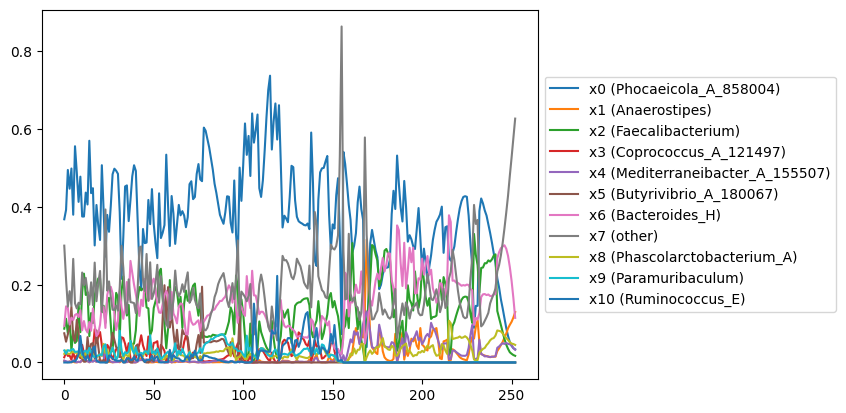

In [23]:
# plot time series over all taxa
fig, ax = plt.subplots()
for i in np.arange(n_taxa):
    ax.plot(T[0], P[0][:,i], label = f"x{i} ({Names[i]})")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### ALR transformation

In [24]:
print(n_taxa)
print(n_samples)
print(taxa_list_mean[1])
print(len(taxa_list_mean[1]))

11
253
[]
0


In [25]:
choose_denom(P)

6

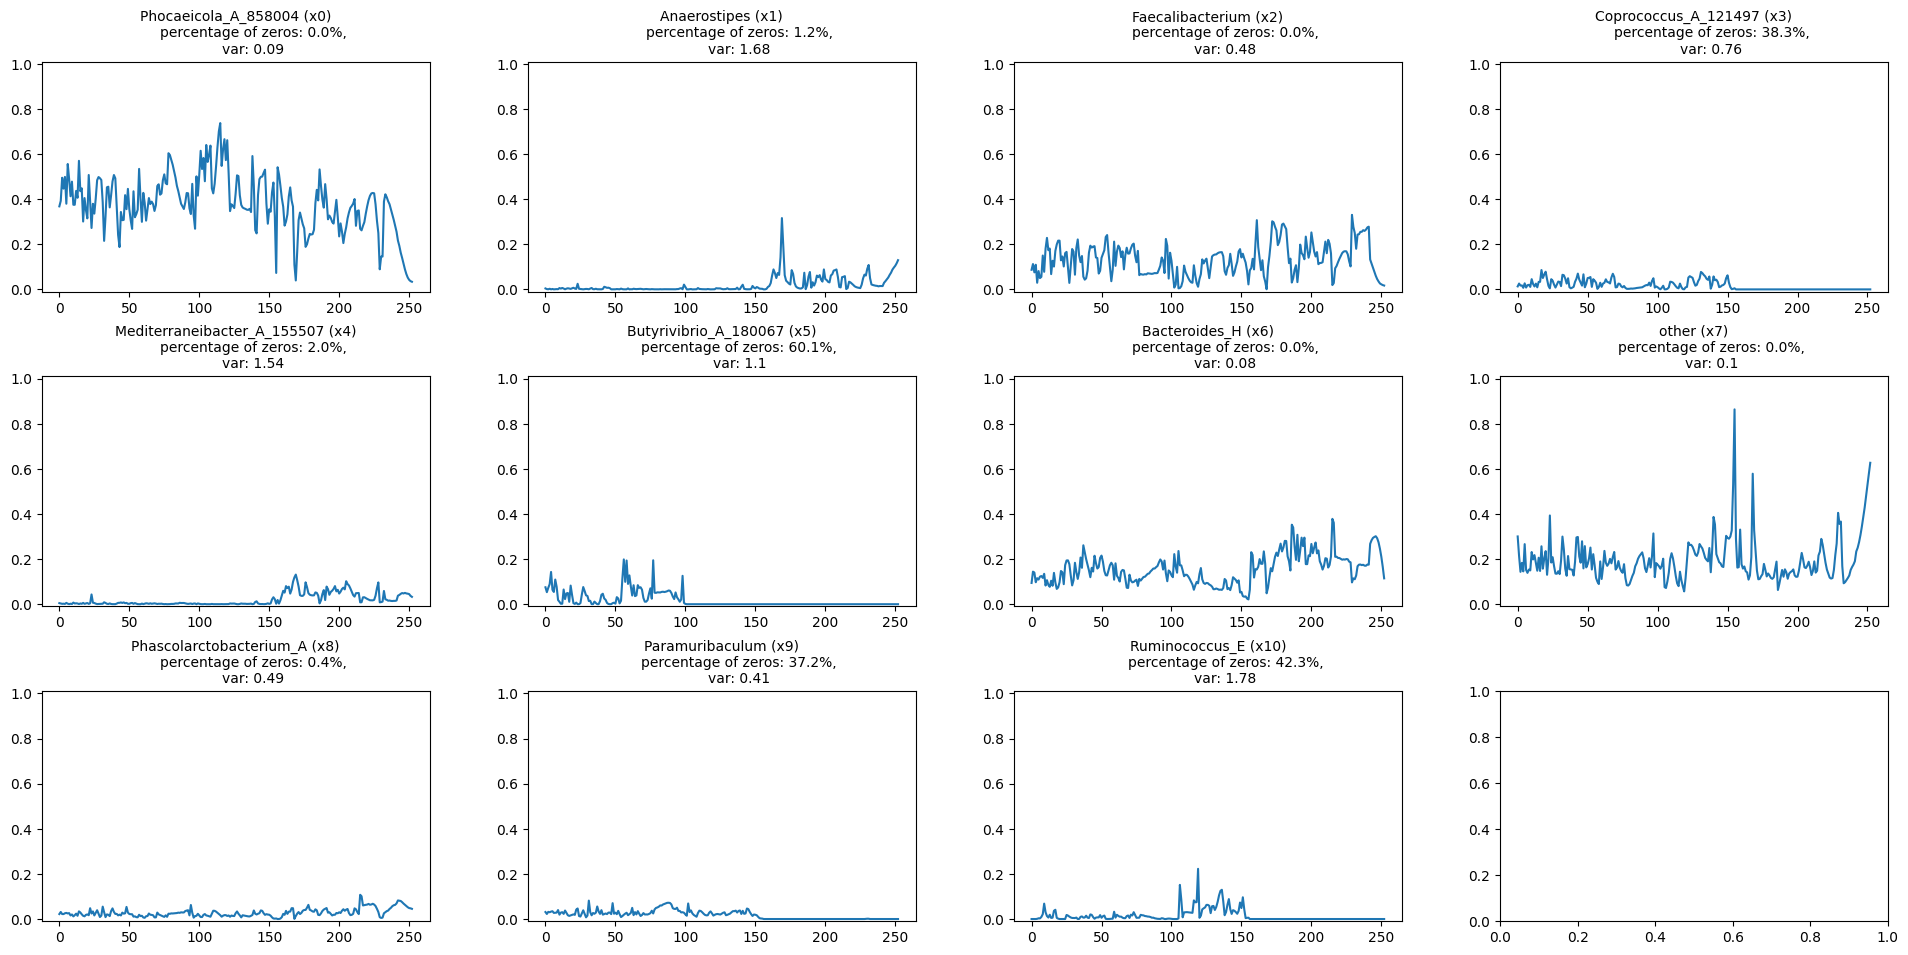

In [26]:
n_row = 3
n_col = 4
fig, axs = plt.subplots(n_row, n_col)
fig.set_figwidth(20)
fig.set_figheight(10)
fig.tight_layout(pad=4.0)
ind=0
# for i in taxa_list_mean[1]:
for i in np.arange(n_taxa):
    # plot each taxon timeline separately
    axs[math.floor(ind/n_col), (ind%n_col)].plot(T[0], P[0][:,i])
    axs[math.floor(ind/n_col), (ind%n_col)].set_title(f"""{Names[i]} (x{i})
        percentage of zeros: {round(sum(Y[0][:,i] == 0)/n_samples*100, 1)}%,
        var: {round(vars[i],2)}""")
    axs[math.floor(ind/n_col), (ind%n_col)].title.set_size(10)
    # axs[math.floor(i/n_col), (i%n_col)].set_ylim([-0.01, (max(max(P[0][:,i]), 0.01) + 0.05)])
    axs[math.floor(ind/n_col), (ind%n_col)].set_ylim([-0.01, 1.01])
    ind += 1

### Plot dataset after ALR transformation

In [27]:
# # plot data after alr for transformation with every otu as denominator
# for denom_tmp in [0, 5]:
#     ALR_tmp = construct_alr(P, denom_tmp)
#     # plot alr
#     fig, ax = plt.subplots()
#     for i in np.arange(n_taxa-1):
#         ax.plot(T[0], ALR_tmp[0][:,i]) #, label = f"x{i+1}"
#     # ax.plot(T[0], Y[0][:, denom_tmp], color='black', linewidth=2)
#     # ax.legend()
#     ax.set_title(f"reference is x{denom_tmp}")

### choose final denominator and do alr transformation

In [28]:
# use choose_denom function to select denominator
# denom = choose_denom(P)
denom = Names.index("other") # for 10_most_abundant_rel_counts datasets
# denom = 5 # or 3 for donorA (PhylumLevel)
# denom = 5 # or 2, 3 for donorB (PhylumLevel)
# denom = 2 # or 4, 5, 0, 1 for female (PhylumLevel)
# denom = 5 # or 2, 0, 1 for male (PhylumLevel)
print(denom)

ALR = construct_alr(P, denom)

7


In [29]:
denom_name = Names.pop(denom)

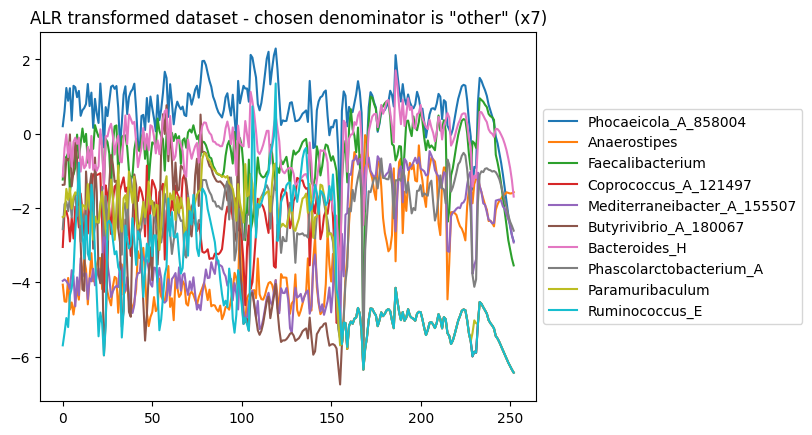

In [30]:
# plot alr transformed time series
fig, ax = plt.subplots()
for i in np.arange(n_taxa-1):
    ax.plot(T[0], ALR[0][:,i], label = Names[i])
ax.set_title(f'ALR transformed dataset - chosen denominator is \"{denom_name}\" (x{denom})')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### save ALR as csv file

In [32]:
# select folderpath for output
folderpath_out = "C:/Users/Maria/Documents/Masterstudium/Masterarbeit/MScThesis/Python/ALR_transformation/ALR_transformed_data/"

# save alr as csv file
df_ALR = pd.DataFrame(data=ALR[0], columns=Names)
df_ALR.insert(0, "Time", T[0])
df_ALR.to_csv(f'{folderpath_out}ALR_denom-{denom}-{denom_name}_{filename}', index=False)

In [ ]:
# # lists of possible references:
# if subject == "donorA":
#     ref_list = [5, 3]
# elif subject == "donorB":
#     ref_list = [5, 2, 3]
# elif subject == "female":
#     ref_list = [2, 4, 5, 0, 1]
# elif subject == "male":
#     ref_list = [5, 2, 0, 1]
# else: 
#     ref_list = [choose_denom(P)]
#
# # save alr as csv file
# for denom in ref_list:
#     ALR = construct_alr(P, denom)
#     df_ALR = pd.DataFrame(ALR[0])
#     df_ALR.insert(0, "Time", T[0])
#     df_ALR.to_csv(f'{filepath}ALR_denom{denom}_{filename}', index=False)